In [7]:
from scipy import io as scio
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as sktransform
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage import feature
from tqdm import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

D:\conda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\conda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\conda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\conda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\conda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [58]:
data = scio.loadmat('./mnist-original.mat')

In [59]:
img_data = data['data']
label_data = data['label']

In [60]:
img_data.shape

(784, 70000)

In [61]:
label_data.shape

(1, 70000)

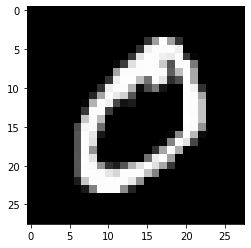

In [62]:
img_sample = np.reshape(img_data[:, 0], [28, 28])
plt.imshow(img_sample, cmap='gray')
plt.show()

In [63]:
dataset = img_data.T
label = label_data.T
print(dataset.shape)
print(label.shape)

(70000, 784)
(70000, 1)


In [ ]:
def get_features_list(img):
    """
    Args:
        path : string :要进行特征提取的图片路径
    Return:
        feature_list : dict : 包含三种特征的字典
    """
    gray_image = img
    otsu_threshold = threshold_otsu(gray_image)
    bin_image = gray_image > otsu_threshold
    # 此处分别使用了水平、竖直、以及45 和135 度方向求 GLCM特征
    feature_glcm = feature.greycomatrix(gray_image, [3], [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4], levels=256)
    hog_feature_vector, hog_image = feature.hog(gray_image, orientations=8, pixels_per_cell=(5, 5),
                                                cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys',
                                                feature_vector=True)
    # 设置LBP 特征提取算法的参数
    radius = 3
    n_points = 8 * radius
    #print(gray_image.dtype)
    feature_lbp = feature.local_binary_pattern(bin_image, n_points, radius, 'uniform')
    feature_glcm_flattened = feature_glcm.flatten()
    feature_hog_flattened = hog_feature_vector
    feature_lbp_flattended = feature_lbp.flatten()
    result = {'glcm': feature_glcm_flattened, 'hog': feature_hog_flattened, 'lbp': feature_lbp_flattended}
    return result

In [ ]:
clf = RandomForestClassifier(n_jobs=-1)

In [ ]:
lbp_feature = []
glcm_feature = []
hog_feature = []

In [ ]:
for img in tqdm(dataset):
    image = np.reshape(img, [28, 28])
    features = get_features_list(image)
    lbp_feature.append(features['lbp'])
#     lbp_feature.append(features['glcm'])
#     lbp_feature.append(features['hog'])

In [ ]:
lbp_feature = np.array(lbp_feature)

In [ ]:
lbp_feature.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(lbp_feature, label, test_size=0.3, random_state=1, shuffle=True)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
test_img = np.reshape(dataset[19999, :], [28, 28])
plt.imshow(test_img)
plt.show()

In [ ]:
lbp = get_features_list(test_img)['lbp']
lbp = np.reshape(lbp, [1, lbp.shape[0]])

In [ ]:
clf.predict(lbp)

In [ ]:
lbp_img = np.reshape(lbp, [28,28])
plt.imshow(lbp_img, cmap='gray')
plt.show()

In [ ]:
pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, pred))

### 使用keras 搭建一个简单的CNN 来实现分类

In [6]:
from keras.layers import Input, Conv1D, Conv2D, MaxPool1D, MaxPool2D, Softmax, GlobalAveragePooling2D, Dense
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model
from keras.utils import to_categorical

In [121]:
def get_model():
    input_tensor = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64 ,kernel_size=(1,1) ,strides=(1, 1), activation='relu')(input_tensor)
    x = MaxPool2D(pool_size=(1, 1), strides=(2,2))(x)
    
    x = Conv2D(filters=128,kernel_size=(3,3), strides=(1, 1), activation='relu')(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    x = Conv2D(filters=256,kernel_size=(3,3), strides=(1, 1), activation='relu')(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)     
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    y = Dense(10,activation='softmax')(x)
    model = Model(input=input_tensor, outputs=y)
    optimizer = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy')
    return model

In [122]:
model = get_model()

D:\conda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  


In [123]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 28, 28, 64)        128       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 2, 2, 256)         0  

In [124]:
y_one_hot = to_categorical(label)
y_one_hot.shape

(70000, 10)

In [125]:
dataset_img = np.reshape(dataset, [dataset.shape[0], 28, 28, 1])

In [126]:
dataset_img.shape

(70000, 28, 28, 1)

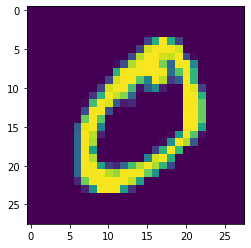

(<matplotlib.image.AxesImage at 0x18855b46688>, None)

In [127]:
plt.imshow(dataset_img[0][:,:,0]),plt.show()

In [128]:
tb = TensorBoard(log_dir='./log', write_graph=True)
model_save = ModelCheckpoint('./model/Mnist-CNN-model.h5',
                             monitor='val_loss',
                             verbose=100,
                             save_best_only=True,
                             save_weights_only=True, 
                             mode='auto',
                             period=10)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10,
                              verbose=0, 
                              mode='auto',
                              min_delta=0.0001, 
                              min_lr=1e-5)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(dataset_img, y_one_hot, test_size=0.3, random_state=1, shuffle=True)

In [130]:
X_train.shape

(49000, 28, 28, 1)

In [131]:
model.fit(X_train, y_train ,batch_size=400,epochs=2,verbose=1,
         callbacks=[lr_reduce, model_save])

Epoch 1/2
49000/49000 [==============================] - ETA: 1:31 - loss: 13.95 - ETA: 1:16 - loss: 16.15 - ETA: 1:11 - loss: 18.66 - ETA: 1:07 - loss: 20.95 - ETA: 1:05 - loss: 21.52 - ETA: 1:04 - loss: 20.38 - ETA: 1:02 - loss: 18.70 - ETA: 1:01 - loss: 16.87 - ETA: 1:00 - loss: 15.32 - ETA: 1:00 - loss: 14.04 - ETA: 59s - loss: 13.0017 - ETA: 58s - loss: 12.127 - ETA: 58s - loss: 11.381 - ETA: 57s - loss: 10.747 - ETA: 57s - loss: 10.196 - ETA: 56s - loss: 9.712 - ETA: 56s - loss: 9.28 - ETA: 55s - loss: 8.89 - ETA: 55s - loss: 8.54 - ETA: 54s - loss: 8.23 - ETA: 53s - loss: 7.95 - ETA: 53s - loss: 7.69 - ETA: 52s - loss: 7.46 - ETA: 52s - loss: 7.24 - ETA: 51s - loss: 7.04 - ETA: 51s - loss: 6.86 - ETA: 50s - loss: 6.69 - ETA: 50s - loss: 6.54 - ETA: 49s - loss: 6.39 - ETA: 48s - loss: 6.25 - ETA: 48s - loss: 6.13 - ETA: 47s - loss: 6.01 - ETA: 47s - loss: 5.89 - ETA: 46s - loss: 5.79 - ETA: 46s - loss: 5.69 - ETA: 45s - loss: 5.59 - ETA: 45s - loss: 5.51 - ETA: 44s - loss: 5.42 -

D:\conda\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/2
49000/49000 [==============================] - ETA: 1:05 - loss: 1.220 - ETA: 1:03 - loss: 1.188 - ETA: 1:03 - loss: 1.190 - ETA: 1:03 - loss: 1.162 - ETA: 1:02 - loss: 1.134 - ETA: 1:02 - loss: 1.112 - ETA: 1:01 - loss: 1.082 - ETA: 1:00 - loss: 1.060 - ETA: 1:00 - loss: 1.044 - ETA: 59s - loss: 1.033 - ETA: 59s - loss: 1.01 - ETA: 58s - loss: 0.99 - ETA: 58s - loss: 0.98 - ETA: 57s - loss: 0.95 - ETA: 57s - loss: 0.94 - ETA: 56s - loss: 0.92 - ETA: 56s - loss: 0.91 - ETA: 55s - loss: 0.89 - ETA: 55s - loss: 0.88 - ETA: 54s - loss: 0.86 - ETA: 54s - loss: 0.85 - ETA: 53s - loss: 0.84 - ETA: 52s - loss: 0.83 - ETA: 52s - loss: 0.82 - ETA: 51s - loss: 0.81 - ETA: 51s - loss: 0.80 - ETA: 50s - loss: 0.78 - ETA: 50s - loss: 0.78 - ETA: 49s - loss: 0.76 - ETA: 49s - loss: 0.76 - ETA: 48s - loss: 0.75 - ETA: 48s - loss: 0.74 - ETA: 47s - loss: 0.73 - ETA: 47s - loss: 0.72 - ETA: 46s - loss: 0.71 - ETA: 46s - loss: 0.70 - ETA: 45s - loss: 0.70 - ETA: 45s - loss: 0.69 - ETA: 44s - l

In [134]:
model.evaluate(X_test, y_test)

21000/21000 [==============================] - ETA: 11 - ETA: 16 - ETA: 17 - ETA: 18 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA

0.2186149250240553

In [137]:
pred = model.predict(X_test)

In [ ]:
import numpy as np

In [141]:
y_test_label = np.array([np.argmax(d) for d in y_test])
y_pre_label = np.array([np.argmax(d) for d in pred])

In [144]:
print(y_test_label.shape)
print(y_pre_label.shape)

(21000,)
(21000,)


In [147]:
from sklearn.metrics import accuracy_score

In [148]:
accuracy_score(y_test_label, y_pre_label)

0.9355238095238095

In [151]:
test_sample = X_test[1001, :, :, :]
test_sample = np.reshape(test_sample, [1, test_sample.shape[0], test_sample.shape[1], test_sample.shape[2]])
test_sample.shape

(1, 28, 28, 1)

In [155]:
test_result = model.predict(test_sample)
print(test_result)
print(np.argmax(test_result))

[[6.7172768e-05 2.3228847e-06 6.6676665e-05 1.5833306e-03 6.2200324e-06
  1.9191639e-02 7.9360162e-04 9.5396308e-07 9.7817695e-01 1.1110102e-04]]
8


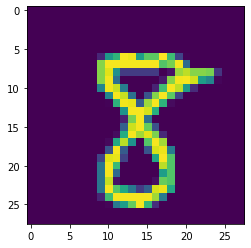

(<matplotlib.image.AxesImage at 0x18847280ac8>, None)

In [156]:
plt.imshow(test_sample[0, :,:, 0]),plt.show()

#### 使用预训练的模型进行分类

In [2]:
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [3]:
from keras.datasets import fashion_mnist

In [4]:
def get_pretrained_model():
    input_tensor = Input(shape=(32, 32, 3))
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling='avg',classes=10)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    y = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs= y)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    return model

In [ ]:
model_vgg = get_pretrained_model()